In [1]:
cd ..

/home/boyochen/dltc


In [2]:
%env CUDA_VISIBLE_DEVICES=-1

from modules.feature_generator import load_dataset
import numpy as np
import pandas as pd

env: CUDA_VISIBLE_DEVICES=-1


2021-12-04 01:44:43.099281: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/home/boyochen/.local/share/virtualenvs/dltc-EZrvkknN/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
data_folder = 'TCSA_fake/'
phase_data = load_dataset(data_folder, 'train', coordinate='polar')

In [4]:
label_df = phase_data['label']
label_df

region       ID          local_time       Vmax       R34    MSLP  \
0         WP  200401W 2004-02-11 09:48:48  15.936704    0.0000  1006.0   
1         WP  200401W 2004-02-11 12:46:48  17.512036    0.0000  1005.0   
2         WP  200401W 2004-02-11 15:44:48  17.476355    0.0000  1004.0   
3         WP  200401W 2004-02-11 18:42:24  20.755124    0.0000  1004.0   
4         WP  200401W 2004-02-11 21:40:24  20.237560    0.0000  1004.0   
...      ...      ...                 ...        ...       ...     ...   
54779     CP  201402C 2014-10-25 13:23:36  60.000000  178.1624   986.0   
54780     CP  201402C 2014-10-25 16:32:00  58.000000  221.1288   988.0   
54781     CP  201402C 2014-10-25 19:40:24  55.000000  263.9100   989.0   
54782     CP  201402C 2014-10-25 22:49:36  52.000000  277.8000   990.0   
54783     CP  201402C 2014-10-26 01:59:12  50.000000  291.6900   992.0   

       valid_profile  
0               True  
1               True  
2               True  
3               True  
4               True  
...              ...  
54779          False  
54780          False  
54781          False  
54782          False  
54783          False  

[54784 rows x 7 columns]

In [5]:
label_df.sort_values(['Vmax'])

region       ID          local_time        Vmax       R34    MSLP  \
52738     IO  201004I 2010-10-24 03:34:24    2.314674   77.5988   998.0   
52739     IO  201004I 2010-10-24 06:39:12    2.359670    0.0000  1000.0   
52737     IO  201004I 2010-10-24 00:29:36    3.961111  155.1976   996.0   
26758     AL  200504L 2005-07-15 09:14:00    4.057159    0.0000  1012.0   
26756     AL  200504L 2005-07-15 03:14:48    4.300072    0.0000  1011.0   
...      ...      ...                 ...         ...       ...     ...   
14184     WP  201331W 2013-11-08 08:18:48  165.000000  229.2776   899.0   
14183     WP  201331W 2013-11-08 05:23:12  168.000000  229.2776   897.0   
14182     WP  201331W 2013-11-08 02:27:36  170.000000  229.2776   895.0   
14181     WP  201331W 2013-11-07 23:32:00  170.000000  224.4624   895.0   
14180     WP  201331W 2013-11-07 20:36:00  170.000000  220.0176   895.0   

       valid_profile  
52738          False  
52739          False  
52737          False  
26758           True  
26756           True  
...              ...  
14184           True  
14183           True  
14182           True  
14181           True  
14180           True  

[54784 rows x 7 columns]

In [6]:
see = phase_data['image'][26758]

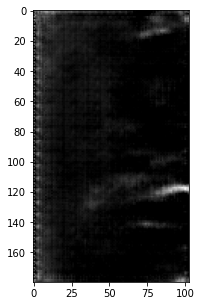

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(see[:, :, 3], cmap='gray')
plt.show()

In [7]:
from main import create_model_by_experiment_path_and_stage

experiment_path = 'experiments/profiler_experiments/W_and_F.yml'
sub_exp_name = 'IR1_PMW'
profiler_IR1_PMW = create_model_by_experiment_path_and_stage(experiment_path, sub_exp_name)

experiment_path = 'experiments/profiler_experiments/W_and_F.yml'
sub_exp_name = 'IR1'
profiler_IR1 = create_model_by_experiment_path_and_stage(experiment_path, sub_exp_name)

experiment_path = 'experiments/GAN_profiler_experiments/five_stage_training.yml'
sub_exp_name = 'profiler_finetune_stage'
GAN_IR1_VIS_PMW = create_model_by_experiment_path_and_stage(experiment_path, sub_exp_name)

In [46]:
from modules.training_helper import rotation_blending

result_df = {
    'profiler_IR1': label_df.copy(),
    'profiler_IR1_PMW': label_df.copy(),
    'GAN_IR1_VIS_PMW': label_df.copy()
}
profiles = {
    'profiler_IR1': [],
    'profiler_IR1_PMW': [],
    'GAN_IR1_VIS_PMW': []
}

for model_name, model in [
    ('profiler_IR1', profiler_IR1),
    ('profiler_IR1_PMW', profiler_IR1_PMW),
    ('GAN_IR1_VIS_PMW', GAN_IR1_VIS_PMW)
]:
    for start, end in [(start, start+step) for step in [100] for start in range(0, 12000, step)]:
        image = phase_data['image'][start:end]
        feature = phase_data['feature'][start:end].to_numpy(dtype='float32')
        label = phase_data['label'][start:end]
        print(start)
        profile, Vmax, R34 = rotation_blending(model, 10, image, feature)
        result_df[model_name].loc[start:end-1, f'{model_name}@pred_Vmax'] = Vmax.numpy()
        result_df[model_name].loc[start:end-1, f'{model_name}@pred_R34'] = R34.numpy()
        profiles[model_name].append(profile.numpy())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000

In [47]:
profile_matrix = {
    model_name: np.concatenate(profile_list)
    for model_name, profile_list in profiles.items()
}

In [67]:
import h5py
for model_name in ['profiler_IR1', 'profiler_IR1_PMW']:
    h5_name = f'{model_name}_output.h5'
    f = h5py.File(h5_name, 'w')
    f['pred_profiles'] = profile_matrix[model_name]
    f.close()
    result_df[model_name].to_hdf(h5_name, 'pred_dataframe')

In [73]:
generated_images = []
for start, end in [(start, start+step) for step in [100] for start in range(0, 12000, step)]:
    print(start)
    image = phase_data['image'][start:end]
    feature = phase_data['feature'][start:end].to_numpy(dtype='float32')
    generated_image = GAN_IR1_VIS_PMW.generate_noon_images(image, feature)
    generated_images.append(generated_image.numpy())

generated_image_matrix = np.concatenate(generated_images)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900


In [82]:
for model_name in ['GAN_IR1_VIS_PMW']:
    h5_name = f'{model_name}_output.h5'
    f = h5py.File(h5_name, 'w')
    f['pred_profiles'] = profile_matrix[model_name]
    f['generated_images'] = generated_image_matrix
    f.close()
    result_df[model_name].to_hdf(h5_name, 'pred_dataframe')

In [71]:
generated_image = GAN_IR1_VIS_PMW.generate_noon_images(image, feature)

<tf.Tensor: shape=(0, 180, 103, 4), dtype=float32, numpy=array([], shape=(0, 180, 103, 4), dtype=float32)>

In [80]:
generated_image_matrix = np.concatenate(generated_images)

In [79]:
np.concatenate(generated_images)

(10952, 180, 103, 4)

In [81]:
generated_image_matrix.shape

(10952, 180, 103, 4)